In [43]:
'''
This code generates box plots for richness indices, comparing different sample sizes using rarefaction.
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

In [195]:
#FUNCTIONS
def get_chao1(df, verbose=False):
    # Sample Data: Species names and their counts (can be from a DataFrame)
    # Let's assume this is a dataset with columns: 'species' and 'count'
    
    # Calculate F1 (singletons) and F2 (doubletons)
    F1 = (df['countSample'] == 1).sum()  # Number of species that appear exactly once
    F2 = (df['countSample'] == 2).sum()  # Number of species that appear exactly twice
    
    # Total observed species (S_obs)
    S_obs = df.shape[0]  # The number of unique species observed
    
    # Chao1 estimator formula
    S_Chao1 = S_obs + (F1 * (F1 - 1)) / (2 * (F2 + 1))
    if verbose:
    # Output the results
        print(f"Observed species (S_obs): {S_obs}")
        print(f"Singletons (F1): {F1}")
        print(f"Doubletons (F2): {F2}")
        print(f"Chao1 Estimate: {S_Chao1}")
    return S_Chao1

def get_chao2(df):
    # Pivot the dataframe to get species counts for each sample
    df_pivot = df.pivot(index='FlowCamID', columns='newName', values='countSample').fillna(0)
    
    # Convert the counts to boolean (0 = species absent, >0 = species present)
    species_counts = df_pivot.astype(bool).sum(axis=0)  # Number of samples each species appears in
    
    # Total number of observed species (S_obs)
    S_obs = len(species_counts)
    
    # Count the number of singletons (species observed exactly once across all samples)
    n1 = sum(1 for count in species_counts if count == 1)
    
    # Count the number of doubletons (species observed exactly twice across all samples)
    n2 = sum(1 for count in species_counts if count == 2)
    
    # Apply the Chao2 formula
    chao2 = S_obs + (n1 ** 2) / (2 * n2) if n2 > 0 else S_obs  # Avoid division by zero if n2 is zero
    
    return chao2


def get_increment(max_num, num_of_intervals):
    divider = max_num - max_num % num_of_intervals    
    return divider / num_of_intervals

def rarefaction_curve(df, max_sample_size, num_of_intervals, num_iterations=1000):
    print('num of species: ', len(df))
    print(df['newName'])
    newNames = df['newName'].to_numpy()
    probs = df['probs'].to_numpy()
    species_counts = df['countSample'].values  # Counts of each species
    name_basket = []
    for i, newName in enumerate(newNames):
        for _ in range(species_counts[i]):
            name_basket.append(newName)
    richness_list = []  # List to store species richness for each sample size
    increment = get_increment(max_sample_size, num_of_intervals)
    print("increment: ", increment)
    for sample_size in range(0, max_sample_size + 1):
        if not sample_size % increment == 0:
            continue
        species_richness = []

        for _ in range(num_iterations):
            # Randomly sample individuals from the species counts
            sampled =np.random.choice(name_basket, sample_size, replace=False)
            # Count the number of unique species observed in this random sample
            observed_species = len(np.unique(sampled))  # Species present if count > 0
            species_richness.append(observed_species)
        richness_list.append(np.mean(species_richness))
        # if np.mean(species_richness) >= len(df):
        #     break
        # Calculate the average species richness for the current sample size
        # print("mean of species_richness: ", np.mean(species_richness))
    return richness_list, increment

def get_rarefaction_value(df, sample_size, num_iterations):
    sum_counts = df['countSample'].sum()
    df['probs'] = df['countSample'] / sum_counts
    # print(df['newName'])
    newNames = df['newName'].to_numpy()
    probs = df['probs'].to_numpy()
    species_counts = df['countSample'].values  # Counts of each species
    name_basket = []
    for i, newName in enumerate(newNames):
        for _ in range(species_counts[i]):
            name_basket.append(newName)
    species_richness = []
    shannons = []
    pielous = []
    for _ in range(num_iterations):
        # Randomly sample individuals from the species counts
        sampled =np.random.choice(name_basket, sample_size, replace=False)
        # Count the number of unique species observed in this random sample
        observed_species = len(np.unique(sampled))  # Species present if count > 0
        species_richness.append(observed_species)
        
        taxa_counts = Counter(sampled)        
        # If you want to get a list of counts (sorted by label)
        counts_list = np.array(list(taxa_counts.values()))
        sample_shannon = shannon_diversity_index(counts_list)
        sample_pielou = pielou_evenness_index(counts_list)
        shannons.append(sample_shannon)
        pielous.append(sample_pielou)
    richness = np.mean(species_richness)
    shannon = np.mean(shannons)
    pielou = np.mean(pielous)
    return richness, shannon, pielou

def plot_rarefaction_curve(df, chao1, num_of_intervals):

    sum_counts = df['countSample'].sum()
    df['probs'] = df['countSample'] / sum_counts
    

    
    # Get the rarefaction curve
    richness, increment = rarefaction_curve(df, min(sum_counts, 8525), 200)
    # Plot the rarefaction curve
    plt.figure(figsize=(8, 6))
    plt.plot(np.array(range(len(richness))) * increment, richness)
    plt.axhline(y=chao1, color='red', linestyle='--', linewidth=2)
    plt.axhline(y=len(df), color='red', linestyle='-', linewidth=2)
    plt.title('Rarefaction Curve')
    plt.xlabel('Number of Individuals Sampled')
    plt.ylabel('Species Richness (Observed Species)')
    plt.grid(True)
    plt.show()
    plt.close()
    return richness, sum_counts, increment, len(df)

def get_redundant_count_names(abunddf, countdf, type):
    typeAbunddf = abunddf[abunddf['type'] == type]
    abundNames = typeAbunddf['newName'].unique()
    countNames = countdf['newName'].unique()
    unique_to_abund = np.setdiff1d(abundNames, countNames)
    unique_to_count = np.setdiff1d(countNames, abundNames)
    print("unique to abund: ", unique_to_abund)
    print("unique to count: ", unique_to_count)
    return unique_to_count


def shannon_diversity_index(species_counts):
    """
    Calculate the Shannon Diversity Index (H') for a given list of species counts.
    
    Parameters:
    species_counts (list or array): A list of counts for each species.

    Returns:
    float: The Shannon Diversity Index (H').
    """
    # Convert counts to proportions
    total_count = np.sum(species_counts)
    
    proportions = species_counts / total_count
    # Remove zero proportions to avoid log(0) issues
    proportions = proportions[proportions > 0]

    # Calculate Shannon index
    shannon_index = -np.sum(proportions * np.log(proportions))
    return shannon_index

def pielou_evenness_index(species_counts):
    """
    Calculate Pielou's Evenness Index (J') for a given list of species counts.
    
    Parameters:
    species_counts (list or array): A list of counts for each species.

    Returns:
    float: Pielou's Evenness Index (J').
    """
    # Total number of species (non-zero counts)
    S = np.sum(species_counts > 0)
    
    if S <= 1:
        # Evenness is undefined for 1 or fewer species
        return 0.0
    
    # Calculate Shannon Diversity Index
    H = shannon_diversity_index(species_counts)
    
    # Calculate Pielou's Evenness Index
    J = H / np.log(S)
    return J

'''FUNCTION FOR DISPLAYING BOXPLOTS
    data = the boxplot data
    ylim = the y-axis limits for the plots
    asterisk_indices = an array of which boxes (regionYears) have asterisks (significant differences)
    asterisk_locs = x and y locations of each asterisk within its subplot
    title = title of each subplot
    figuretitle = title of the whole plot
    return void
'''
def display_boxplots(data, ylim, asterisk_indices, asterisk_locs, title, figuretitle):
    print(data)
    regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for r, regionYear in enumerate(regionYears):
        if regionYear == 'Gulf':
            types = ['CI-u', 'CI', 'HI', 'HM']
        else:
            types = ['CI', 'HI', 'HM']
        print(types)
        
        ax = axes[r]
        bplot = ax.boxplot(data[regionYear], patch_artist=True, medianprops=dict(color='blue', linewidth=2))
        # Set x-ticks labels for each boxplot
        colors = ['#75ba75', '#fec76f', '#be95be']
        if len(types) > 3:
            colors = ['#49f549', '#75ba75', '#fec76f', '#be95be']
        ax.set_xticks(range(1, len(types) + 1), types, fontsize=14)
        # ax.set_yticks([])
        # if regionYear != 'Gulf':
        #     ax.tick_params(axis='y', labelleft=False)  
        # ax.set_xticks()
        # Add title and labels
        ax.set_title(regionYear, fontsize=14)
        ax.set_ylim(ylim)
        
    # fill with colors
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        # ax.set_xlabel('Classification Method')
        # ax.set_ylabel('Number of Unique Taxa per Sample')
    
    # Set a single y-label on the left side for all subplots
    axes[0].set_ylabel(f"{title}\nper Sample", fontsize=14)
    for i, index in enumerate(asterisk_indices):
        print(i)
        print(asterisk_locs[i])
        axes[index].text(asterisk_locs[i][0], asterisk_locs[i][1], '*', fontsize=20, color='black', ha='center', va='center')
    
    # Set a single x-label at the bottom in the center for all subplots
    fig.text(0.5, -0.05, "Sorting Process", ha='center', va='center', fontsize=14)
    fig.text(0.1, 1, f"({figuretitle})", ha='right', va='center', fontsize=14)  
    # Show the plot
    plt.show()
    plt.close()

def test_assumptions(dataset, verbose=False):
    for regionYear in regionYears:
        for _ in range(3):
            print('#############################')
        print('-------------------', regionYear, '------------------------')
        for _ in range(3):
            print('#############################')
        if regionYear == 'Gulf':
            types = [1, 2, 3]
        else:
            types = [0, 1, 2]
        for type in types:
            print('----------------------------', regionYear, type)
            rawdata = dataset[regionYear][type]
            # print('before: ', rawdata)
            data = np.log(rawdata)
            # print('after: ', data)
            # print('before again: ', rawdata)
            if verbose:
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                # Plot the first histogram (normal distribution)
                axes[0].hist(rawdata, bins=30, color='blue', alpha=0.7)
                axes[0].set_title('Raw Data')
                axes[0].set_xlabel('Value')
                axes[0].set_ylabel('Frequency')
                # Plot the second histogram (log-normal distribution)
                axes[1].hist(data, bins=30, color='green', alpha=0.7)
                axes[1].set_title('Log-normal transform')
                axes[1].set_xlabel('Value')
                axes[1].set_ylabel('Frequency')
                plt.show()
                plt.close()
            # Perform the Shapiro-Wilk test
            statistic, p_value = stats.shapiro(rawdata)
            
            # Print results
            print(f"Shapiro-Wilk Test Statistic: {statistic}")
            print(f"P-value: {p_value}")
        
            # Interpret the result
            if p_value > 0.05:
                print(f"The data is normally distributed (p = {p_value:.3f})")
            else:
                print('NOT NORMAL----------------------------------------')
                print(f"The data is not normally distributed (p = {p_value:.3f})")
            # Perform the Shapiro-Wilk test
            print('------------------', 'AFTER LOG TRANSFORM', '-----------')
            statistic, p_value = stats.shapiro(data)
            
            # Print results
            print(f"Shapiro-Wilk Test Statistic: {statistic}")
            print(f"P-value: {p_value}")
        
            # Interpret the result
            if p_value > 0.05:
                print(f"The data is normally distributed (p = {p_value:.3f})")
            else:
                print('NOT NORMAL----------------------------------------')
                print(f"The data is not normally distributed (p = {p_value:.3f})")
        print('###########', 'Levene Time', '################')
        for combo in [[types[0], types[1]], [types[0], types[2]], [types[1], types[2]]]:
            
            # Perform Levene's test for homogeneity of variances
            stat, p_value = stats.levene(dataset[regionYear][combo[0]] , dataset[regionYear][combo[1]])
            # Print the test statistic and p-value
            print(f"Levene's test statistic: {stat}")
            print(f"P-value: {p_value*3}")
        print('Levene after Log Transform')
        for combo in [[0, 1], [0, 2], [1, 2]]:
            
            # Perform Levene's test for homogeneity of variances
            stat, p_value = stats.levene(np.log(dataset[regionYear][combo[0]]) , np.log(dataset[regionYear][combo[1]]))
            # Print the test statistic and p-value
            print(f"Levene's test statistic: {stat}")
            print(f"P-value: {p_value*3}")

def friedman_and_posthoc(datasets, name):
    print('------------------------')
    print(name)
    for regionYear in regionYears:
        print('-------------', regionYear, '-------------------')
        if regionYear == 'Gulf':
           # Example data (related groups)
            list1 = datasets[regionYear][1]
            list2 = datasets[regionYear][2]
            list3 = datasets[regionYear][3]
        else:
        # Example data (related groups)
            list1 = datasets[regionYear][0]
            list2 = datasets[regionYear][1]
            list3 = datasets[regionYear][2]
        
        # Step 1: Perform Friedman Test
        stat, p = friedmanchisquare(list1, list2, list3)
        print(f"Friedman Test: Chi-square statistic = {stat}, p-value = {p}")
        
        if p < 0.05:
            print("Significant differences found. Proceeding with pairwise comparisons.")
            
            # Step 2: Perform pairwise Wilcoxon Signed-Rank Tests
            data = [list1, list2, list3]
            labels = ['CI', 'HI', 'HM']
            comparisons = combinations(range(len(data)), 2)  # Generate pairwise indices
            
            for i, j in comparisons:
                # print(data[i], data[j])
                print(f"Mean of {labels[i]}: {np.mean(data[i])}, Mean of {labels[j]}: {np.mean(data[j])}")
                stat, p = wilcoxon(data[i], data[j])
                print(f"Wilcoxon Test ({labels[i]} vs {labels[j]}): Statistic = {stat}, p-value = {p*3}")
        else:
            print("No significant differences found. No need for pairwise comparisons.")

In [3]:

nameChangesFile = pd.ExcelFile('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperZooNameChanges.xlsx')
sheet_names = nameChangesFile.sheet_names
nameChanges = pd.read_excel(nameChangesFile, sheet_names[1])
ogNames = nameChanges['flowcamName'].to_numpy()
newNames = nameChanges['newName'].to_numpy()
changeDict = {}
for i, ogname in enumerate(ogNames):
    changeDict[ogname] = newNames[i]

changeDict['Chaetognatha (juvenile or n.s.)']= 'Chaetognatha'
changeDict['Sarsia_spp_medusa']= 'Sarsia spp. (medusa)'


In [4]:
datadf = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperDataForFigures.xlsx')

In [5]:
# this cleans the the redundant taxa from the microscopy data (like eggs)

hm_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/microscopyDataMethodPaper_RawCounts.xlsx')
hm_rawcounts_df = hm_rawcounts_df[['FlowCamID', 'newName', 'regionYear', 'Subsample fraction', 'countSample']]
#check which names are in rawcounts but not in the abundance data sheet. Remove them and print them.
hm_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hm_rawcounts_df, 'MC')
print(len(hm_rawcounts_df['newName'].unique()))
hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(hm_rawcounts_df_redundant_names)]
len(hm_rawcounts_df['newName'].unique())

unique to abund:  []
unique to count:  ['Decapoda: Distribute abundances between non-brachyura and brachyura'
 'Egg mass: REMOVE' 'Invertebrate (egg, trochophore larvae)']
50


47

In [6]:
#rename problem taxa

newName_removals = ['Alciopidae sp.', 'Neoturris spp. (medusa)', 'Scyphozoa (medusa)']

newName_changes = {'Ctenophora (juvenile/adult)': 'Ctenophora (larvae)',
                  'Amphipoda- epibenthic': 'Amphipoda',
                   'Calycophorae (nectophore)': 'Siphonophorae (nectophore)',
                   'Ctenophora larvae': 'Ctenophora (larvae)'
                  }


hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(newName_removals)]
hm_rawcounts_df = hm_rawcounts_df.replace(newName_changes)
hm_rawcounts_df = hm_rawcounts_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })
hm_names = hm_rawcounts_df['newName'].unique()
hm_names.sort()
print(len(hm_names))
hm_names

43


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Ascidiacea (larvae)', 'Bivalvia (larvae)', 'Bryozoa (larvae)',
       'Calanoida (ci-ciii)', 'Calanus spp.', 'Centropages spp.',
       'Chaetognatha', 'Cirripedia (larvae)', 'Copepoda (nauplii)',
       'Corycaeidae', 'Ctenophora (larvae)',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Epilabidocera spp.', 'Eurytemora spp.',
       'Evadne spp.', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)',
       'Isopoda (larvae)', 'Leuckartiara spp. (medusa)',
       'Microcalanus spp.', 'Obelia spp. (medusa)', 'Oikopleura spp.',
       'Oithona spp.', 'Osteichthyes (larvae)', 'Paracalanus spp.',
       'Platyhelminthes/Nemertea (juvenile)',
       'Platyhelminthes/Nemertea (larvae)', 'Podon/Pleopsis spp.',
       'Polychaeta (larvae)', 'Pseudocalanus spp.',
       'Pseudodiaptomus spp.', 'Sarsia spp. (me

In [204]:
sampleCounts = hm_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
print(smallest_sample)

hm_richness_dict = {}
hm_shannon_dict = {}
hm_pielou_dict = {}
regionYears = hm_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    hm_richness_dict[regionYear] = []
    hm_shannon_dict[regionYear] = []
    hm_pielou_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        hm_richness_dict[regionYear].append(richness)
        hm_shannon_dict[regionYear].append(shannon)
        hm_pielou_dict[regionYear].append(pielou)

203
------------ NL 2021 ------------
richness:  14.696 shannon:  1.8785961380246616 pielou:  0.7002632715565635
richness:  14.681 shannon:  1.8809508672273234 pielou:  0.7015071272085324
richness:  15.82 shannon:  1.993108956019507 pielou:  0.7227577299874892
richness:  13.573 shannon:  1.721409807697773 pielou:  0.6616600593863791
richness:  13.884 shannon:  1.7161855988103678 pielou:  0.6537038491736953
richness:  15.546 shannon:  2.0053107632214697 pielou:  0.7318862196777293
richness:  16.136 shannon:  1.991123340194505 pielou:  0.7168405085655695
richness:  16.505 shannon:  2.006690999851882 pielou:  0.7168557291605441
richness:  14.016 shannon:  2.009637792825292 pielou:  0.7626672156024508
richness:  12.183 shannon:  1.886380415746824 pielou:  0.7563532645816058
------------ NL 2020 ------------
richness:  7.997 shannon:  1.2554846777638116 pielou:  0.6038808273701162
richness:  7.708 shannon:  1.153651195240766 pielou:  0.5659241844196136
richness:  8.447 shannon:  1.258962137

In [9]:
hi_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/flowcamDataMethodPaper_RawCounts.xlsx')
hi_rawcounts_df = hi_rawcounts_df[['qaSampleID', 'originalNames', 'dataset', 'fracSampleCleaned', 'count']]
hi_rawcounts_df = hi_rawcounts_df.rename(columns={'qaSampleID': 'FlowCamID', 'originalNames': 'newName', 'dataset':'regionYear', 'count': 'countSample'})
hi_rawcounts_df['newName'] = hi_rawcounts_df['newName'].replace(changeDict)
hi_rawcounts_df['regionYear'] = hi_rawcounts_df['regionYear'].replace({'Newfoundland 2020': 'NL 2020', 'Pacific June 2021': 'Pacific', 'Newfoundland 2021': 'NL 2021', 'Gulf 2020': 'Gulf'})
hi_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hi_rawcounts_df, 'FC')
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Oncaeidae_Civ-vi']
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Sarsia spp. (medusa)']
print(len(hi_rawcounts_df['newName'].unique()))
hi_rawcounts_df = hi_rawcounts_df[~hi_rawcounts_df['newName'].isin(hi_rawcounts_df_redundant_names)]
print(len(hi_rawcounts_df['newName'].unique()))
hi_names = hi_rawcounts_df['newName'].unique()
hi_names.sort()
hi_names

unique to abund:  []
unique to count:  ['Calanoida (unid)' 'Copepoda (unid)' 'Cyclopoida (unid)'
 'Invertebrate (egg, trochophore larvae)' 'Oncaeidae_Civ-vi'
 'Osteichthyes egg' 'Osteichthyes_eggs' 'Sarsia spp. (medusa)'
 'Zooplankton (unid)']
55
48


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Anthoathecata (medusa)', 'Ascidiacea (larvae)',
       'Bivalvia (larvae)', 'Bryozoa (larvae)', 'Calanoida (ci-ciii)',
       'Calanus spp.', 'Calycophorae (nectophore)', 'Centropages spp.',
       'Chaetognatha', 'Chiridius spp.', 'Cirripedia (larvae)',
       'Cnidaria (larvae)', 'Copepoda (nauplii)', 'Corycaeidae',
       'Ctenophora larvae', 'Decapoda- brachyura (larvae)',
       'Decapoda- non-brachyura (larvae)', 'Echinodermata (larvae)',
       'Euphysa spp. (medusa)', 'Eurytemora spp.', 'Evadne spp.',
       'Foraminifera', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Oncaeidae_Civ-vi', 'Osteichthyes (larvae)', 'Ostracoda',
       'Paracalanus spp.', 'Podon/Pleopsis spp.', 'Polychaeta (larvae

In [205]:
sampleCounts = hi_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
print('smallest sample: ', smallest_sample)
hm_smallest_sample = 203
hi_richness_dict = {}
hi_shannon_dict = {}
hi_pielou_dict = {}
regionYears = hi_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    hi_richness_dict[regionYear] = []
    hi_shannon_dict[regionYear] = []
    hi_pielou_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, hm_smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        hi_richness_dict[regionYear].append(richness)
        hi_shannon_dict[regionYear].append(shannon)
        hi_pielou_dict[regionYear].append(pielou)

smallest sample:  800
------------ NL 2020 ------------
richness:  7.527 shannon:  1.1346118252665929 pielou:  0.5652416529234684
richness:  7.514 shannon:  1.1354424792957116 pielou:  0.5707285685496442
richness:  8.581 shannon:  1.3067974947189478 pielou:  0.6120566005968909
richness:  7.754 shannon:  1.2690480373736868 pielou:  0.6250596279342135
richness:  7.636 shannon:  1.3338074759163696 pielou:  0.6669744563907187
richness:  8.25 shannon:  1.2473113794986572 pielou:  0.599686991959085
richness:  9.041 shannon:  1.310466520358292 pielou:  0.5999327834224077
richness:  7.81 shannon:  1.2376247044831201 pielou:  0.6087941308619446
richness:  8.835 shannon:  1.3874293518570053 pielou:  0.6437254417335976
richness:  7.428 shannon:  1.257432061993959 pielou:  0.637739240405245
------------ NL 2021 ------------
richness:  14.484 shannon:  1.89086358010683 pielou:  0.7095045142361273
richness:  14.132 shannon:  1.8617065398744208 pielou:  0.7049539892429145
richness:  18.825 shannon:  

In [206]:
cidf = pd.read_excel('five_thousand_strat4_abunds_Feb4.xlsx')
cidf = cidf[cidf['type'] == 'CI']
ci_rawcounts_df = cidf.rename(columns={'abund': 'countSample'})
ci_rawcounts_df = ci_rawcounts_df.replace(newName_changes)
ci_rawcounts_df = ci_rawcounts_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })

In [207]:
sampleCounts = ci_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
smallest_sample = int(smallest_sample)
print('smallest sample: ', smallest_sample)
ci_samples = {}
ci_richness_dict = {}
ci_shannon_dict = {}
ci_pielou_dict = {}
regionYears = ci_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    ci_richness_dict[regionYear] = []
    ci_shannon_dict[regionYear] = []
    ci_pielou_dict[regionYear] = []
    ci_samples[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        ci_samples[regionYear].append(sample)
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        sample_counts['countSample'] = sample_counts['countSample'].astype(int)
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, hm_smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        ci_richness_dict[regionYear].append(richness)
        ci_shannon_dict[regionYear].append(shannon)
        ci_pielou_dict[regionYear].append(pielou)

smallest sample:  786
------------ NL 2021 ------------
richness:  16.081 shannon:  1.9161398896260906 pielou:  0.691207237526363
richness:  15.939 shannon:  1.9360967761413344 pielou:  0.7006836339020208
richness:  16.935 shannon:  2.09167876364709 pielou:  0.740423516918316
richness:  15.12 shannon:  1.9960994069475 pielou:  0.7368076254876285
richness:  16.347 shannon:  2.000591444812847 pielou:  0.7174305184552607
richness:  17.514 shannon:  2.0865325101244836 pielou:  0.7301019860265736
richness:  16.445 shannon:  1.9753885892233314 pielou:  0.70722482189683
richness:  16.827 shannon:  2.1335113591859636 pielou:  0.7569021714590035
richness:  15.878 shannon:  2.1157392275244464 pielou:  0.7665665980930698
richness:  16.474 shannon:  2.0377486340331923 pielou:  0.728323464023907
------------ Gulf ------------
richness:  17.209 shannon:  1.7099489511247887 pielou:  0.6019184555796888
richness:  17.061 shannon:  2.203848119484692 pielou:  0.7783728078441391
richness:  16.298 shannon:

In [208]:
ci_samples

{'NL 2021': ['21_10_05_NL_S1_Z17_0752_250',
  '21_10_05_NL_S1_Z17_1406_250',
  '21_10_05_NL_S1_Z41_0854_250',
  '21_10_05_NL_S1_Z41_1327_250',
  '21_10_06_NL_S1_Z17_0802_250',
  '21_10_06_NL_S1_Z17_1442_250',
  '21_10_06_NL_S1_Z41_0839_250',
  '21_10_06_NL_S1_Z41_1412_250',
  '21_10_07_NL_S1_Z17_0830_250',
  '21_10_07_NL_S1_Z17_1459_250'],
 'Gulf': ['AMMP_Gulf_StPeters_1_20200903HT_250UM',
  'AMMP_Gulf_StPeters_1_20200903LT_250UM',
  'AMMP_Gulf_StPeters_1_20200904HT_250UM',
  'AMMP_Gulf_StPeters_2B_20200903_250UM',
  'AMMP_Gulf_StPeters_2_20200903HT_250UM',
  'AMMP_Gulf_StPeters_2_20200904HT_250UM',
  'AMMP_Gulf_StPeters_3B_20200903_250UM',
  'AMMP_Gulf_StPeters_3_20200903HT_250UM',
  'AMMP_Gulf_StPeters_3_20200903LT_250UM',
  'AMMP_Gulf_StPeters_3_20200904HT_250UM'],
 'NL 2020': ['AMMP_NL_S01_33_20200916AM_250UM',
  'AMMP_NL_S01_33_20200916PM_250UM',
  'AMMP_NL_S01_41_20200916AM_250UM',
  'AMMP_NL_S01_41_20200916PM_250UM',
  'AMMP_NL_S01_51_20200915PM_250UM',
  'AMMP_NL_S01_51_2020091

In [203]:
%store ci_samples
%store ci_richness_dict
%store ci_shannon_dict
%store ci_pielou_dict

Stored 'ci_samples' (dict)
Stored 'ci_richness_dict' (dict)
Stored 'ci_shannon_dict' (dict)
Stored 'ci_pielou_dict' (dict)


In [209]:

max_cidf = pd.read_excel('max_strat4_abunds_Feb4.xlsx')
max_cidf = max_cidf[max_cidf['type'] == 'CI']
max_ci_rawcounts_df = max_cidf.rename(columns={'abund': 'countSample'})
max_ci_rawcounts_df = max_ci_rawcounts_df.replace(newName_changes)
max_ci_rawcounts_df = max_ci_rawcounts_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })

In [210]:
sampleCounts = max_ci_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
smallest_sample = int(smallest_sample)
print('smallest sample: ', smallest_sample)

max_ci_richness_dict = {}
max_ci_shannon_dict = {}
max_ci_pielou_dict = {}
regionYears = max_ci_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    max_ci_richness_dict[regionYear] = []
    max_ci_shannon_dict[regionYear] = []
    max_ci_pielou_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = max_ci_rawcounts_df[max_ci_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        sample_counts['countSample'] = sample_counts['countSample'].astype(int)
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, hm_smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        max_ci_richness_dict[regionYear].append(richness)
        max_ci_shannon_dict[regionYear].append(shannon)
        max_ci_pielou_dict[regionYear].append(pielou)

smallest sample:  786
------------ NL 2021 ------------
richness:  15.799 shannon:  1.8984083600685466 pielou:  0.6892158094295581
richness:  15.529 shannon:  1.8961196309043098 pielou:  0.6929996466276498
richness:  16.694 shannon:  2.075834970756714 pielou:  0.7385255901697548
richness:  14.767 shannon:  1.982815858150299 pielou:  0.7382227674584168
richness:  16.437 shannon:  1.9980683919289177 pielou:  0.7150850137675645
richness:  17.597 shannon:  2.0837334908335805 pielou:  0.727888900242381
richness:  16.037 shannon:  1.9652422722918332 pielou:  0.7101081465331258
richness:  16.766 shannon:  2.1170072869894194 pielou:  0.7523838101741133
richness:  15.701 shannon:  2.1061159776199387 pielou:  0.7662953962282613
richness:  15.946 shannon:  2.0332310475050503 pielou:  0.7351251532190544
------------ Gulf ------------
richness:  15.523 shannon:  1.6633539798691148 pielou:  0.6075963680553487
richness:  13.129 shannon:  1.6855199619552201 pielou:  0.6565104731817615
richness:  15.04

In [211]:
richness_box_data = {}
shannon_box_data = {}
pielou_box_data = {}
for regionYear in regionYears:
    richness_box_data[regionYear] = []
    if regionYear == 'Gulf':
        richness_box_data[regionYear].append(max_ci_richness_dict[regionYear])
    richness_box_data[regionYear].append(ci_richness_dict[regionYear])
    richness_box_data[regionYear].append(hi_richness_dict[regionYear])
    richness_box_data[regionYear].append(hm_richness_dict[regionYear])

    shannon_box_data[regionYear] = []
    if regionYear == 'Gulf':
        shannon_box_data[regionYear].append(max_ci_shannon_dict[regionYear])
    shannon_box_data[regionYear].append(ci_shannon_dict[regionYear])
    shannon_box_data[regionYear].append(hi_shannon_dict[regionYear])
    shannon_box_data[regionYear].append(hm_shannon_dict[regionYear])

    pielou_box_data[regionYear] = []
    if regionYear == 'Gulf':
        pielou_box_data[regionYear].append(max_ci_pielou_dict[regionYear])
    pielou_box_data[regionYear].append(ci_pielou_dict[regionYear])
    pielou_box_data[regionYear].append(hi_pielou_dict[regionYear])
    pielou_box_data[regionYear].append(hm_pielou_dict[regionYear])


In [212]:
def get_mean_and_se(dataset):
    regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
    for regionYear in regionYears:
        print('---------------', regionYear, '--------------')
        type_num = len(dataset[regionYear])
        if type_num > 3:
            types = ['CI-u', 'CI', 'HI', 'HM']
        else:
            types = ['CI', 'HI', 'HM']
        for t, type in enumerate(types):
            print('###', type, '###')
            datarow = dataset[regionYear][t]
            print("mean: ", np.mean(datarow))
            se = np.std(datarow, ddof=1)/np.sqrt(len(datarow))
            print("se: ", se)

get_mean_and_se(richness_box_data)

--------------- Gulf --------------
### CI-u ###
mean:  12.9251
se:  0.5604076383411553
### CI ###
mean:  16.101300000000002
se:  0.3105632535321017
### HI ###
mean:  8.244900000000001
se:  1.070260388358314
### HM ###
mean:  9.567899999999998
se:  1.1258291803525673
--------------- Pacific --------------
### CI ###
mean:  18.6112
se:  0.26638234008866096
### HI ###
mean:  17.083199999999998
se:  0.33274383874419383
### HM ###
mean:  20.6419
se:  0.40929121525985473
--------------- NL 2020 --------------
### CI ###
mean:  12.3763
se:  0.13321486820588432
### HI ###
mean:  8.037600000000001
se:  0.1880617629042828
### HM ###
mean:  9.2163
se:  0.4847796761874867
--------------- NL 2021 --------------
### CI ###
mean:  16.356
se:  0.2088504515463424
### HI ###
mean:  15.690800000000001
se:  0.4460186792301664
### HM ###
mean:  14.703999999999999
se:  0.4220266447617837


In [213]:
get_mean_and_se(shannon_box_data)

--------------- Gulf --------------
### CI-u ###
mean:  1.6007230663959888
se:  0.0733299360458327
### CI ###
mean:  1.9432647306963022
se:  0.0632732250759743
### HI ###
mean:  1.117601374222978
se:  0.12636368681204607
### HM ###
mean:  1.4208669808388938
se:  0.10781417795441518
--------------- Pacific --------------
### CI ###
mean:  2.1349447115441413
se:  0.015145726511149874
### HI ###
mean:  1.956002521555326
se:  0.036487406703412
### HM ###
mean:  2.2857935134891707
se:  0.03112877859496911
--------------- NL 2020 --------------
### CI ###
mean:  1.816262499596397
se:  0.01671356811429641
### HI ###
mean:  1.261997133076234
se:  0.025466679657987934
### HM ###
mean:  1.3059081478177172
se:  0.03773527376834401
--------------- NL 2021 --------------
### CI ###
mean:  2.0289526601266283
se:  0.024012391019877437
### HI ###
mean:  1.92677664652273
se:  0.02898745238862752
### HM ###
mean:  1.9089394679619605
se:  0.03611033255845977


In [214]:
get_mean_and_se(pielou_box_data)

--------------- Gulf --------------
### CI-u ###
mean:  0.6280989868768405
se:  0.02237258653343667
### CI ###
mean:  0.7012913245748742
se:  0.02234761436492492
### HI ###
mean:  0.5431423958565147
se:  0.03293171940991614
### HM ###
mean:  0.6478087053904438
se:  0.027360266208676598
--------------- Pacific --------------
### CI ###
mean:  0.731628830126885
se:  0.0043029496000446905
### HI ###
mean:  0.6906903459283512
se:  0.010231275042173213
### HM ###
mean:  0.7563061184407468
se:  0.010150168166710966
--------------- NL 2020 --------------
### CI ###
mean:  0.7249657124816662
se:  0.0060004540761937454
### HI ###
mean:  0.6129939494777216
se:  0.010027218673977267
### HM ###
mean:  0.5919623963887202
se:  0.0102165533901827
--------------- NL 2021 --------------
### CI ###
mean:  0.7275671573788973
se:  0.007601533969707528
### HI ###
mean:  0.7022481948237795
se:  0.007156559352610293
### HM ###
mean:  0.7124494974900559
se:  0.011190749874856005


{'NL 2021': [[16.081, 15.939, 16.935, 15.12, 16.347, 17.514, 16.445, 16.827, 15.878, 16.474], [14.484, 14.132, 18.825, 14.818, 17.087, 14.614, 15.268, 16.008, 15.802, 15.87], [14.696, 14.681, 15.82, 13.573, 13.884, 15.546, 16.136, 16.505, 14.016, 12.183]], 'Gulf': [[15.523, 13.129, 15.044, 10.808, 12.38, 11.394, 11.409, 12.045, 15.402, 12.117], [17.209, 17.061, 16.298, 15.135, 15.224, 15.325, 15.373, 15.417, 17.887, 16.084], [6.335, 5.026, 11.822, 7.65, 5.184, 7.203, 14.019, 12.929, 6.959, 5.322], [8.045, 4.75, 11.655, 7.407, 8.81, 8.079, 14.625, 16.01, 9.826, 6.472]], 'NL 2020': [[12.336, 12.768, 12.952, 12.3, 12.155, 12.08, 12.84, 11.511, 12.379, 12.442], [7.527, 7.514, 8.581, 7.754, 7.636, 8.25, 9.041, 7.81, 8.835, 7.428], [7.997, 7.708, 8.447, 8.73, 10.704, 9.291, 10.543, 8.318, 12.425, 8.0]], 'Pacific': [[18.089, 18.892, 18.484, 18.842, 19.083, 16.475, 19.367, 19.141, 18.558, 19.181], [17.629, 15.666, 16.158, 16.667, 17.525, 17.226, 18.927, 16.742, 15.944, 18.348], [20.277, 22.9, 

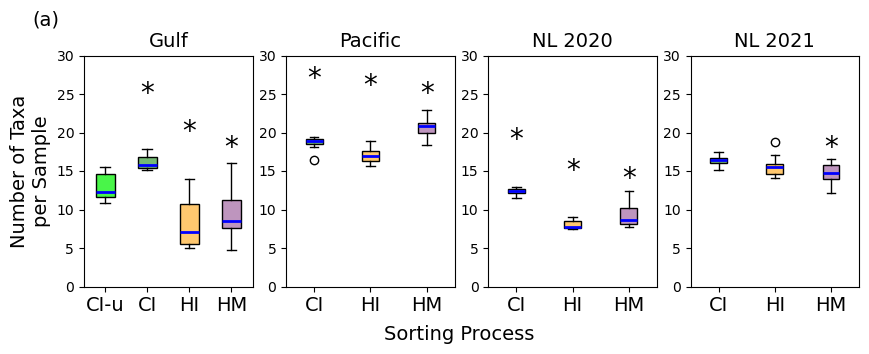

{'NL 2021': [[16.081, 15.939, 16.935, 15.12, 16.347, 17.514, 16.445, 16.827, 15.878, 16.474], [14.484, 14.132, 18.825, 14.818, 17.087, 14.614, 15.268, 16.008, 15.802, 15.87], [14.696, 14.681, 15.82, 13.573, 13.884, 15.546, 16.136, 16.505, 14.016, 12.183]], 'Gulf': [[15.523, 13.129, 15.044, 10.808, 12.38, 11.394, 11.409, 12.045, 15.402, 12.117], [17.209, 17.061, 16.298, 15.135, 15.224, 15.325, 15.373, 15.417, 17.887, 16.084], [6.335, 5.026, 11.822, 7.65, 5.184, 7.203, 14.019, 12.929, 6.959, 5.322], [8.045, 4.75, 11.655, 7.407, 8.81, 8.079, 14.625, 16.01, 9.826, 6.472]], 'NL 2020': [[12.336, 12.768, 12.952, 12.3, 12.155, 12.08, 12.84, 11.511, 12.379, 12.442], [7.527, 7.514, 8.581, 7.754, 7.636, 8.25, 9.041, 7.81, 8.835, 7.428], [7.997, 7.708, 8.447, 8.73, 10.704, 9.291, 10.543, 8.318, 12.425, 8.0]], 'Pacific': [[18.089, 18.892, 18.484, 18.842, 19.083, 16.475, 19.367, 19.141, 18.558, 19.181], [17.629, 15.666, 16.158, 16.667, 17.525, 17.226, 18.927, 16.742, 15.944, 18.348], [20.277, 22.9, 

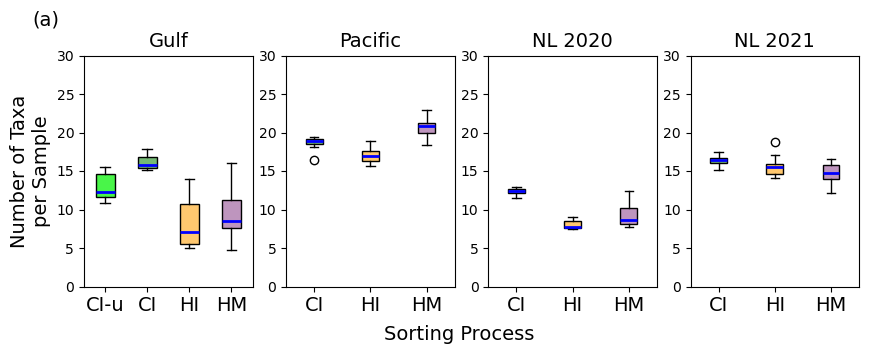

In [216]:
display_boxplots(richness_box_data, [0, 30], [0, 0, 0, 1, 1, 1, 2, 2, 2, 3], 
                 [[2, 25], [3, 20], [4, 18],
                  [1, 27], [2, 26], [3, 25], 
                  [1, 19], [2, 15], [3, 14], 
                  [3, 18]],
                 'Number of Taxa', 'a')

display_boxplots(richness_box_data, [0, 30], [], 
                 [],
                 'Number of Taxa', 'a')

In [156]:
regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']

In [196]:
test_assumptions(richness_box_data, False)

#############################
#############################
#############################
------------------- Gulf ------------------------
#############################
#############################
#############################
---------------------------- Gulf 1
Shapiro-Wilk Test Statistic: 0.9588894507699376
P-value: 0.773138470061974
The data is normally distributed (p = 0.773)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.9537858613107871
P-value: 0.7133562211530722
The data is normally distributed (p = 0.713)
---------------------------- Gulf 2
Shapiro-Wilk Test Statistic: 0.854284171895419
P-value: 0.06531041489900614
The data is normally distributed (p = 0.065)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.9011990570569804
P-value: 0.22582770431833626
The data is normally distributed (p = 0.226)
---------------------------- Gulf 3
Shapiro-Wilk Test Statistic: 0.9306125453178554
P-value: 0.4539442553901653


In [158]:

friedman_and_posthoc(richness_box_data, 'RICHNESS')

# friedman_and_posthoc(pielou_box_data, 'PIELOU')

------------------------
RICHNESS
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 18.200000000000017, p-value = 0.0001116658084901137
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 20.839900000000004, Mean of HI: 11.2455
Wilcoxon Test (CI vs HI): Statistic = 0.0, p-value = 0.005859375
Mean of CI: 20.839900000000004, Mean of HM: 9.5708
Wilcoxon Test (CI vs HM): Statistic = 0.0, p-value = 0.005859375
Mean of HI: 11.2455, Mean of HM: 9.5708
Wilcoxon Test (HI vs HM): Statistic = 4.0, p-value = 0.041015625
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 11.400000000000006, p-value = 0.003345965457471265
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 23.548099999999998, Mean of HI: 22.597099999999998
Wilcoxon Test (CI vs HI): Statistic = 8.0, p-value = 0.146484375
Mean of CI: 23.548099999999998, Mean of HM: 20.6236
Wilcoxon Test (CI vs HM): Statistic = 0.0, p-value

In [159]:
test_assumptions(shannon_box_data, False)

#############################
#############################
#############################
------------------- Gulf ------------------------
#############################
#############################
#############################
---------------------------- Gulf 0
before:  [1.698464333950856, 1.719113434660749, 1.6197939175234197, 1.2911000287081122, 1.7099568803924396, 1.4262002815892079, 1.442514167992319, 1.7924095718108723, 2.1159913761001827, 1.5083972143727955]
after:  [0.52972451 0.54180871 0.48229893 0.25549459 0.53646815 0.35501376
 0.36638754 0.58356084 0.74952344 0.41104764]
before again:  [1.698464333950856, 1.719113434660749, 1.6197939175234197, 1.2911000287081122, 1.7099568803924396, 1.4262002815892079, 1.442514167992319, 1.7924095718108723, 2.1159913761001827, 1.5083972143727955]
Shapiro-Wilk Test Statistic: 0.9501770270452407
P-value: 0.6705953422850532
The data is normally distributed (p = 0.671)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Sta

In [160]:
friedman_and_posthoc(shannon_box_data, 'SHANNON')

------------------------
SHANNON
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 11.400000000000006, p-value = 0.003345965457471265
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 1.983557272170381, Mean of HI: 1.1366498455488896
Wilcoxon Test (CI vs HI): Statistic = 1.0, p-value = 0.01171875
Mean of CI: 1.983557272170381, Mean of HM: 1.4217046866727399
Wilcoxon Test (CI vs HM): Statistic = 2.0, p-value = 0.017578125
Mean of HI: 1.1366498455488896, Mean of HM: 1.4217046866727399
Wilcoxon Test (HI vs HM): Statistic = 3.0, p-value = 0.029296875
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 14.599999999999994, p-value = 0.0006755387751938461
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 2.18044005758467, Mean of HI: 2.0003293964777678
Wilcoxon Test (CI vs HI): Statistic = 1.0, p-value = 0.01171875
Mean of CI: 2.18044005758467, Mean of HM: 2.2849437354766
Wilco

{'NL 2021': [[1.9551041440026673, 1.9776618294040358, 2.1296894418646426, 2.035091447553412, 2.0450504400201, 2.1347715885148655, 2.014695561811494, 2.1716076055902094, 2.1548047167642816, 2.073605066365547], [1.92740901935006, 1.8980527528355593, 2.191031758343145, 1.9520290873290025, 1.9148640419789094, 1.9397027953415695, 1.841398343125797, 2.041815843733381, 1.9860847801133132, 1.9784125371159091], [1.8806619665476838, 1.883579988594483, 1.9920858307821423, 1.7213898451554719, 1.7077869058716055, 2.008093273358139, 1.9892559340718217, 2.0036035783585873, 2.006748318587101, 1.8899696542061324]], 'Gulf': [[1.698464333950856, 1.719113434660749, 1.6197939175234197, 1.2911000287081122, 1.7099568803924396, 1.4262002815892079, 1.442514167992319, 1.7924095718108723, 2.1159913761001827, 1.5083972143727955], [1.7493742561070338, 2.2457979153232954, 1.636346003506109, 1.932748148906622, 2.094884121433948, 1.9178400895331316, 1.927548192835036, 2.1339130377747124, 2.229760245009432, 1.96736071

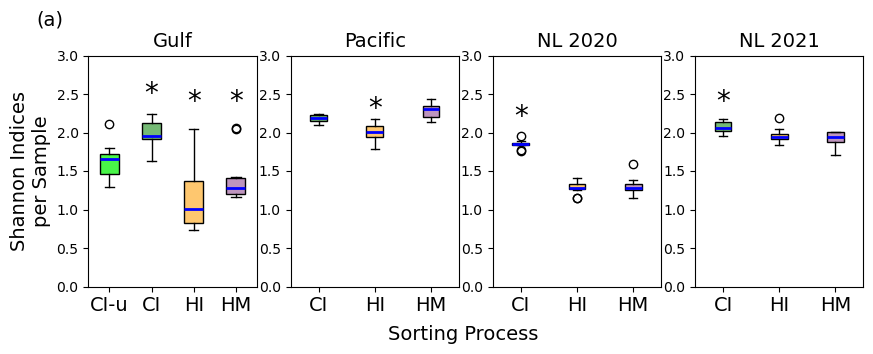

In [161]:
display_boxplots(shannon_box_data, [0, 3], [0, 0, 0, 1, 2, 3], 
                 [[2, 2.5], [3, 2.4], [4, 2.4],
                  [2, 2.3], 
                  [1, 2.2], 
                  [1, 2.4]],
                 'Shannon Indices', 'a')

In [162]:
test_assumptions(shannon_box_data, False)

#############################
#############################
#############################
------------------- Gulf ------------------------
#############################
#############################
#############################
---------------------------- Gulf 0
before:  [1.698464333950856, 1.719113434660749, 1.6197939175234197, 1.2911000287081122, 1.7099568803924396, 1.4262002815892079, 1.442514167992319, 1.7924095718108723, 2.1159913761001827, 1.5083972143727955]
after:  [0.52972451 0.54180871 0.48229893 0.25549459 0.53646815 0.35501376
 0.36638754 0.58356084 0.74952344 0.41104764]
before again:  [1.698464333950856, 1.719113434660749, 1.6197939175234197, 1.2911000287081122, 1.7099568803924396, 1.4262002815892079, 1.442514167992319, 1.7924095718108723, 2.1159913761001827, 1.5083972143727955]
Shapiro-Wilk Test Statistic: 0.9501770270452407
P-value: 0.6705953422850532
The data is normally distributed (p = 0.671)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Sta

In [163]:
friedman_and_posthoc(pielou_box_data, 'PIELOU')

------------------------
PIELOU
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 13.400000000000006, p-value = 0.0012309119026734777
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 0.6544415588938642, Mean of HI: 0.4747857481666398
Wilcoxon Test (CI vs HI): Statistic = 2.0, p-value = 0.017578125
Mean of CI: 0.6544415588938642, Mean of HM: 0.6483178933025933
Wilcoxon Test (CI vs HM): Statistic = 23.0, p-value = 2.0859375
Mean of HI: 0.4747857481666398, Mean of HM: 0.6483178933025933
Wilcoxon Test (HI vs HM): Statistic = 0.0, p-value = 0.005859375
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 18.200000000000017, p-value = 0.0001116658084901137
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 0.6904109856408442, Mean of HI: 0.6418332006492002
Wilcoxon Test (CI vs HI): Statistic = 2.0, p-value = 0.017578125
Mean of CI: 0.6904109856408442, Mean of HM: 0.756244924650

{'NL 2021': [[0.6422231363012088, 0.6512395354084619, 0.7006545803026699, 0.6793302143582671, 0.6637227636166074, 0.6814546645376836, 0.6531316507704973, 0.7249004274383706, 0.7212151741156048, 0.693943847792289], [0.6243931619117066, 0.6375505048395955, 0.6911218109474894, 0.6629545054730989, 0.6134762199410413, 0.6507051150588786, 0.6090905656575832, 0.6709788727925758, 0.64542659053148, 0.652083846459994], [0.7004316533533672, 0.7019131628004333, 0.7210963812736015, 0.6605771776759606, 0.6499685836345256, 0.7323843655318724, 0.7153244304727937, 0.715289007804047, 0.7617792267876519, 0.7551379957213057]], 'Gulf': [[0.5709553926115776, 0.6047394152670483, 0.5473651467730263, 0.4673962816887659, 0.6176600514712018, 0.5092222093340754, 0.5301898887397213, 0.6601443287049289, 0.7258214628716455, 0.5381372745102763], [0.5624250717445946, 0.7278081659586851, 0.5385119198628853, 0.6318885185793358, 0.7138067172236711, 0.6324134339395878, 0.643637234127322, 0.7219969045982285, 0.721866169070

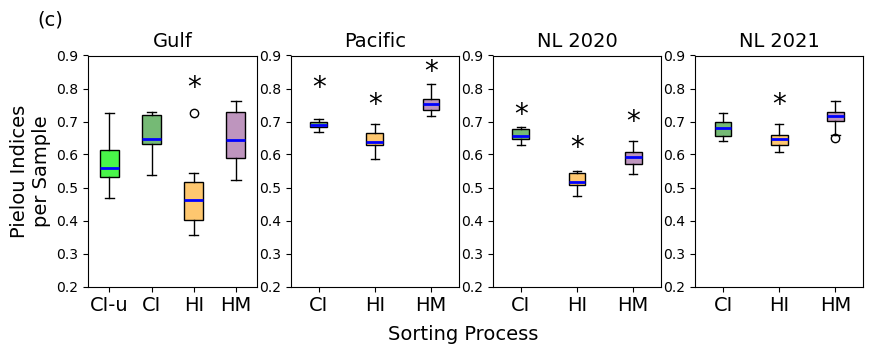

In [164]:
display_boxplots(pielou_box_data, [0.2, 0.9], [0, 1, 1, 1, 2, 2, 2, 3], 
                 [[3, .8],
                  [1, 0.8], [2, 0.75], [3, 0.85], 
                  [1, 0.72], [2, 0.62], [3, 0.70], 
                  [2, 0.75]],
                 'Pielou Indices', 'c')

In [165]:
regional_richness = {}
for regionYear in regionYears:
    regional_richness[regionYear] = []
    if regionYear == 'Gulf':
        regional_richness[regionYear].append(len(max_ci_rawcounts_df[max_ci_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
    regional_richness[regionYear].append(len(ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
    regional_richness[regionYear].append(len(hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
    regional_richness[regionYear].append(len(hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
regional_richness

{'Gulf': [26, 29, 32, 21],
 'Pacific': [25, 29, 37],
 'NL 2020': [24, 27, 16],
 'NL 2021': [24, 29, 25]}

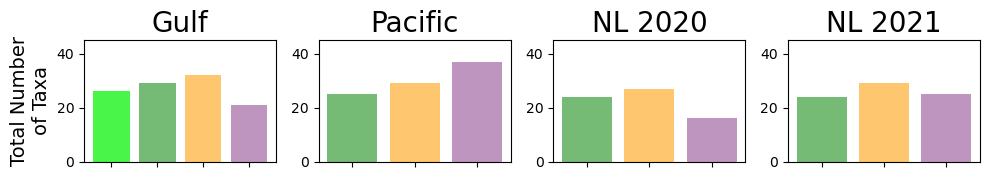

In [166]:
#small bar graphs for total species richness in all ten samples for each sorting process and regionYear
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

# Loop through each regionYear and corresponding subplot
for i, regionYear in enumerate(regionYears):
    ax = axes[i]  # Access the correct subplot
    if i == 0:
        colors = ['#49f549', '#75ba75', '#fec76f', '#be95be']
        thisRichness = regional_richness[regionYear]
        ax.bar([1, 2, 3, 4], thisRichness, color=colors)
        ax.set_xticks([1, 2, 3, 4], [])
    # Create the bar plot in the current subplot
    else:
        colors = ['#75ba75', '#fec76f', '#be95be']
        ax.bar([1, 2, 3], regional_richness[regionYear], color=colors)
        ax.set_xticks([1, 2, 3], ['' for type in [1, 2, 3]])
    ax.set_title(regionYear, fontsize=20)  # Set the title for the subplot
    # ax.set_xlabel("Classification Method")  # Example x-axis label
    
    
    ax.set_ylim([0, 45])
# Adjust layout to avoid overlap
axes[0].set_ylabel("Total Number\nof Taxa", fontsize=14)    # Example y-axis label
# fig.text(0.5, 0, "Sorting Process", ha='center', va='center', fontsize=14)
# fig.text(0.04, .9, f"(a)", ha='right', va='center', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle("Number of Taxa Identified by Region and Method", fontsize=14)
# Show the plot
plt.show()

In [145]:
max_ci_rawcounts_df[max_ci_rawcounts_df['countSample'] > 0]

,newName,FlowCamID,type,regionYear,countSample
0,Acartia spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,276.0
1,Bivalvia (larvae),21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
2,Bryozoa (larvae),21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,10.0
3,Calanoida (ci-ciii),21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,52.0
4,Calanus spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
...,...,...,...,...,...
2225,Podon/Pleopsis spp.,AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,59.0
2226,Polychaeta (larvae),AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,6.0
2227,Pseudocalanus spp.,AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,2.0
2228,Siphonophorae (nectophore),AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,14.0


In [146]:
max_ci_rawcounts_df[max_ci_rawcounts_df['newName'] == 'Calanus spp.']

,newName,FlowCamID,type,regionYear,countSample
4,Calanus spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
65,Calanus spp.,21_10_05_NL_S1_Z17_1406_250,CI,NL 2021,1.0
124,Calanus spp.,21_10_05_NL_S1_Z41_0854_250,CI,NL 2021,5.0
242,Calanus spp.,21_10_06_NL_S1_Z17_0802_250,CI,NL 2021,1.0
302,Calanus spp.,21_10_06_NL_S1_Z17_1442_250,CI,NL 2021,2.0
364,Calanus spp.,21_10_06_NL_S1_Z41_0839_250,CI,NL 2021,2.0
426,Calanus spp.,21_10_06_NL_S1_Z41_1412_250,CI,NL 2021,4.0
546,Calanus spp.,21_10_07_NL_S1_Z17_1459_250,CI,NL 2021,1.0
603,Calanus spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI,Gulf,5.0
1002,Calanus spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,CI,Gulf,3.0


In [147]:
ci_rawcounts_df[ci_rawcounts_df['newName'] == 'Calanus spp.']

,newName,FlowCamID,type,regionYear,countSample
4,Calanus spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
65,Calanus spp.,21_10_05_NL_S1_Z17_1406_250,CI,NL 2021,1.0
124,Calanus spp.,21_10_05_NL_S1_Z41_0854_250,CI,NL 2021,5.0
242,Calanus spp.,21_10_06_NL_S1_Z17_0802_250,CI,NL 2021,1.0
302,Calanus spp.,21_10_06_NL_S1_Z17_1442_250,CI,NL 2021,2.0
364,Calanus spp.,21_10_06_NL_S1_Z41_0839_250,CI,NL 2021,2.0
426,Calanus spp.,21_10_06_NL_S1_Z41_1412_250,CI,NL 2021,4.0
546,Calanus spp.,21_10_07_NL_S1_Z17_1459_250,CI,NL 2021,1.0
603,Calanus spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI,Gulf,5.0
1002,Calanus spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,CI,Gulf,3.0


In [172]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

# Example lists (each list corresponds to measurements for a different condition)
list_A = [20, 21, 22, 23, 24]  # Measurements for condition A
list_B = [22, 23, 24, 25, 26]  # Measurements for condition B
list_C = [24, 25, 26, 27, 28]  # Measurements for condition C

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Subject': [1, 2, 3, 4, 5],  # Subject IDs
    'Condition_A': list_A,
    'Condition_B': list_B,
    'Condition_C': list_C
})

# Reshape the data into long format
df_long = pd.melt(df, id_vars='Subject', value_vars=['Condition_A', 'Condition_B', 'Condition_C'],
                  var_name='Condition', value_name='Measurement')

# Perform Repeated Measures ANOVA
anova = AnovaRM(df_long, 'Measurement', 'Subject', within=['Condition'])
result = anova.fit()

# Print the result
print(result)


                              Anova
                        F Value               Num DF Den DF Pr > F
------------------------------------------------------------------
Condition 264093875047547803706603864064.0000 2.0000 8.0000 0.0000



In [181]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

def rm_anova(dataset):
    for regionYear in regionYears:
        if regionYear == 'Gulf':
            list_A = dataset[regionYear][1]
            list_B = dataset[regionYear][2]
            list_C = dataset[regionYear][3]
        else:
            list_A = dataset[regionYear][0]
            list_B = dataset[regionYear][1]
            list_C = dataset[regionYear][2]            
        # Create a DataFrame from the lists
        df = pd.DataFrame({
            'Sample': list(range(1, 11)),
            'CI': list_A,
            'HI': list_B,
            'HM': list_C
        })
        
        # Reshape the data into long format
        df_long = pd.melt(df, id_vars='Sample', value_vars=['CI', 'HI', 'HM'],
                          var_name='Sorting_Process', value_name='Measurement')
        
        # Perform Repeated Measures ANOVA
        anova = AnovaRM(df_long, 'Measurement', 'Sample', within=['Sorting_Process'])
        result = anova.fit()
        
        # Extract specific statistics
        # Accessing the summary table of the results
        print(result.summary())
rm_anova(shannon_box_data)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Sorting_Process 24.3338 2.0000 18.0000 0.0000

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Sorting_Process 21.8196 2.0000 18.0000 0.0000

                    Anova
                F Value  Num DF  Den DF Pr > F
----------------------------------------------
Sorting_Process 171.7390 2.0000 18.0000 0.0000

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Sorting_Process 12.7908 2.0000 18.0000 0.0003



In [190]:
import numpy as np
import pandas as pd
from scipy.stats import chi2


def check_sphericity(dataset):
    for regionYear in regionYears:
        if regionYear == 'Gulf':
            list_A = dataset[regionYear][1]
            list_B = dataset[regionYear][2]
            list_C = dataset[regionYear][3]
        else:
            list_A = dataset[regionYear][0]
            list_B = dataset[regionYear][1]
            list_C = dataset[regionYear][2]            
        # Create a DataFrame from the lists
        df = pd.DataFrame({
            'Sample': list(range(1, 11)),
            'CI': list_A,
            'HI': list_B,
            'HM': list_C
        })
        print(df)
        # Step 1: Calculate the difference matrix
        # First, subtract each pair of conditions
        diff_AB = df['CI'] - df['HI']
        diff_AC = df['CI'] - df['HM']
        diff_BC = df['HI'] - df['HM']
        
        # Stack the differences into a matrix
        diff_matrix = np.vstack([diff_AB, diff_AC, diff_BC]).T  # Each row corresponds to a subject
        
        # Step 2: Calculate the covariance matrix of the differences
        cov_matrix = np.cov(diff_matrix.T)
        print(cov_matrix)
        # Step 3: Check if the covariance matrix is singular (determinant is 0)
        det_cov_matrix = np.linalg.det(cov_matrix)
        
        if det_cov_matrix == 0:
            print("Warning: The covariance matrix is singular (determinant = 0), which means the data may not have enough variation.")
            W = np.nan  # Set W to NaN if the covariance matrix is singular
        else:
            # Step 4: Calculate Mauchly's test statistic (W)
            variances = np.diagonal(cov_matrix)
        
            # Check if any of the variances are zero
            if np.any(variances == 0):
                print("Warning: One or more variances are zero. Mauchly's test cannot be calculated.")
                W = np.nan  # Set W to NaN if variances are zero
            else:
                # Calculate W
                W = det_cov_matrix / np.prod(variances)
        
        # Step 5: Compute the p-value using a chi-square distribution if W is valid
        if not np.isnan(W):
            # Degrees of freedom = number of conditions - 1
            df_sphericity = 3 - 1  # Since there are 3 conditions, the df is 3 - 1 = 2
            p_value = 1 - chi2.cdf(W * (len(df) - 1), df_sphericity)
        
            print(f"Mauchly's W: {W}")
            print(f"Degrees of Freedom: {df_sphericity}")
            print(f"Chi-squared p-value: {p_value}")
        
            if p_value < 0.05:
                print("Sphericity assumption is violated (p < 0.05).")
            else:
                print("Sphericity assumption holds (p >= 0.05).")
        else:
            print("Mauchly's test could not be computed due to issues with the data (singular matrix or zero variance).")
check_sphericity(richness_box_data)

   Sample      CI      HI      HM
0       1  22.500   9.040   8.012
1       2  21.945   6.722   4.718
2       3  20.926  16.264  11.672
3       4  21.366  10.707   7.428
4       5  18.875   7.111   8.822
5       6  20.819  10.008   8.080
6       7  20.025  16.768  14.671
7       8  19.267  17.743  15.969
8       9  22.014  10.001   9.860
9      10  20.662   8.091   6.476
[[22.03077693 18.94966884 -3.08110809]
 [18.94966884 18.72213854 -0.2275303 ]
 [-3.08110809 -0.2275303   2.85357779]]
Mauchly's test could not be computed due to issues with the data (singular matrix or zero variance).
   Sample      CI      HI      HM
0       1  23.210  24.520  20.215
1       2  23.607  22.365  22.882
2       3  23.256  21.320  21.694
3       4  24.479  22.705  19.303
4       5  24.638  22.766  18.303
5       6  21.734  21.386  20.558
6       7  23.915  24.289  21.036
7       8  23.621  22.378  19.846
8       9  23.130  21.137  21.173
9      10  23.891  23.105  21.226
[[ 1.22334267  0.36113322 -0.8622